The code is written in google colab where the leaves folder needs to be copied


# **Randomly rotate, shift, scale and warp**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import os
import glob
import random

def random_transformation(image):
    rows, cols, ch = image.shape

    # Random rotation
    angle = np.random.randint(-30, 30)
    M_rotate = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M_rotate, (cols, rows))

    # Random shifting
    tx = np.random.randint(-10, 10)
    ty = np.random.randint(-10, 10)
    M_shift = np.float32([[1, 0, tx], [0, 1, ty]])
    shifted_image = cv2.warpAffine(rotated_image, M_shift, (cols, rows))

    # Random scaling
    scale = np.random.uniform(0.9, 1.1)
    scaled_image = cv2.resize(shifted_image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    rows, cols, ch = scaled_image.shape

    # Random warping
    random_quad = np.float32([
        [np.random.randint(0, cols / 4), np.random.randint(0, rows / 4)],
        [np.random.randint(3 * cols / 4, cols), np.random.randint(0, rows / 4)],
        [np.random.randint(0, cols / 4), np.random.randint(3 * rows / 4, rows)],
        [np.random.randint(3 * cols / 4, cols), np.random.randint(3 * rows / 4, rows)]
    ])

    original_quad = np.float32([
        [0, 0],
        [cols, 0],
        [0, rows],
        [cols, rows]
    ])

    M_warp = cv2.getPerspectiveTransform(original_quad, random_quad)
    warped_image = cv2.warpPerspective(scaled_image, M_warp, (cols, rows))

    return warped_image

# Paths
folder_path = '/content/drive/MyDrive/Agricultural_Image_Analytics/AgandBio/leaves'
output_folder = '/content/drive/MyDrive/Agricultural_Image_Analytics/AgandBio/leaves/transformed'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load all images from the folder
leaf_images = [cv2.imread(file) for file in glob.glob(folder_path + '/*.png')]
print(len(leaf_images))

# Ensure all images are loaded properly
leaf_images = [img for img in leaf_images if img is not None]

# Generate 100 images
for i in range(100):
    # Randomly pick an index for one of the leaf images
    idx = random.randint(0, len(leaf_images) - 1)
    original_image = leaf_images[idx]
    new_image = random_transformation(original_image)

    # Save the transformed image
    cv2.imwrite(os.path.join(output_folder, f'transformed_image_{i+1}.jpg'), new_image)

print('Transformed images have been saved.')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
8
Transformed images have been saved.


# **Generating the patches**

In [5]:
import cv2
import numpy as np
import os
import glob
import random

# Function to extract a random patch from an image
def extract_random_patch(image, patch_size=(50, 50)):
    max_y = image.shape[0] - patch_size[0]
    max_x = image.shape[1] - patch_size[1]

    # Ensure the image is larger than the patch size
    if max_y <= 0 or max_x <= 0:
        raise ValueError("Patch size is larger than the image size.")

    x = random.randint(0, max_x)
    y = random.randint(0, max_y)

    patch = image[y:y+patch_size[0], x:x+patch_size[1]]
    return patch

# Path to the folder containing the 100 transformed images
transformed_images_folder = '/content/drive/MyDrive/Agricultural_Image_Analytics/AgandBio/leaves/transformed'

# Output folder for the patches
patches_output_folder = '/content/drive/MyDrive/Agricultural_Image_Analytics/AgandBio/leaves/patches'

# Create the output folder if it doesn't exist
if not os.path.exists(patches_output_folder):
    os.makedirs(patches_output_folder)

# Load all transformed images from the folder
transformed_images = [cv2.imread(file) for file in glob.glob(transformed_images_folder + '/*.jpg')]

# Ensure all images are loaded properly
transformed_images = [img for img in transformed_images if img is not None]

# Extract and save a patch from each transformed image
for idx, image in enumerate(transformed_images):
    try:
        patch = extract_random_patch(image, patch_size=(50, 50))  # Specify your patch size here
        cv2.imwrite(os.path.join(patches_output_folder, f'patch_{idx+1}.jpg'), patch)
    except ValueError as e:
        print(f"Error extracting patch from image {idx+1}: {e}")

print('Patches have been extracted and saved.')


Patches have been extracted and saved.


# **ZCA Whitening**

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load images from a folder along with their filenames
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                filenames.append(filename)
    return np.array(images), filenames

# Define your folder path
folder_path = '/content/drive/MyDrive/Agricultural_Image_Analytics/AgandBio/leaves/patches'

# Load images
X, filenames = load_images_from_folder(folder_path)

# Reshape images
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])

# Convert to float32
X = X.astype(np.float32)

# Normalize pixel values to range [0, 1]
X_norm = X / 255.0

# Mean subtraction
X_norm = X_norm - X_norm.mean(axis=0)

# Covariance matrix and ZCA whitening
cov = np.cov(X_norm, rowvar=False)
U, S, V = np.linalg.svd(cov)
epsilon = 0.1
X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_norm.T).T
X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())


# Define the output folder to save the plots
output_folder = '/content/drive/MyDrive/Agricultural_Image_Analytics/AgandBio/leaves/prewhitened_images'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Function to plot and save images
def plotImageAndSave(X, index, output_folder):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(X[index].reshape(50, 50, 3))
    plt.axis('off')  # Turn off axis
    plt.savefig(os.path.join(output_folder, f'image_{index}.png'), bbox_inches='tight', pad_inches=0)  # Save plot as PNG
    plt.close()

# Plot and save all whitened images
for i in range(len(X_ZCA_rescaled)):
    plotImageAndSave(X_ZCA_rescaled, i, output_folder)

# **Channel by Channel for prewhitened patches**

Red Channel - Mean: 0.3189894121234172, Median: 0.31274878668687156, Std: 0.043628103732201357, Skewness: 0.9807810312063662, Kurtosis: 3.7662648942644754


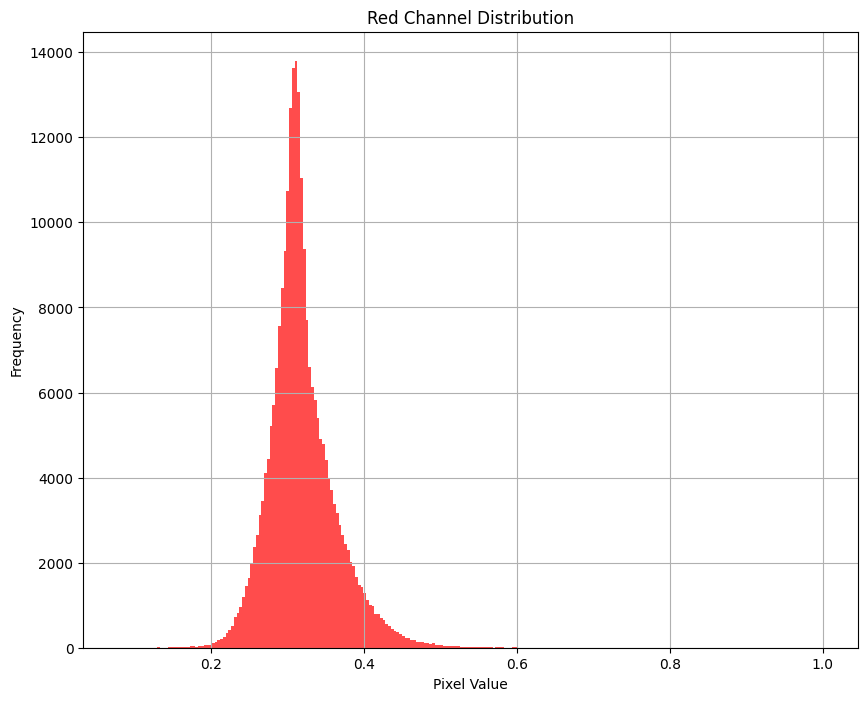

Green Channel - Mean: 0.31898941333902375, Median: 0.31330295448432177, Std: 0.04906055313555689, Skewness: 0.42939611220343077, Kurtosis: 2.5473036837045813


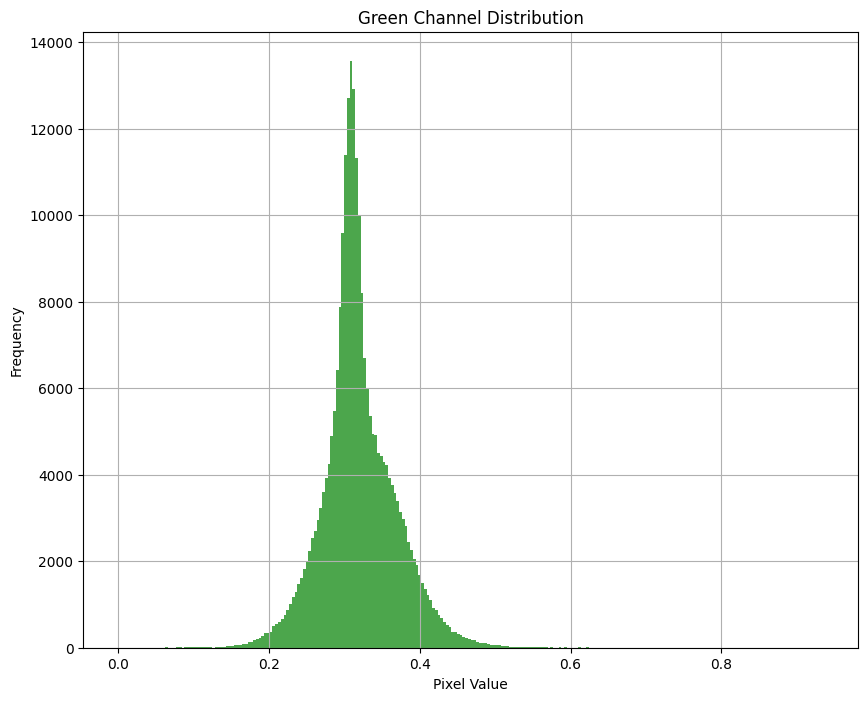

Blue Channel - Mean: 0.31898940983371354, Median: 0.31416925925617567, Std: 0.04478953060672238, Skewness: 0.914918855438596, Kurtosis: 3.477998121543272


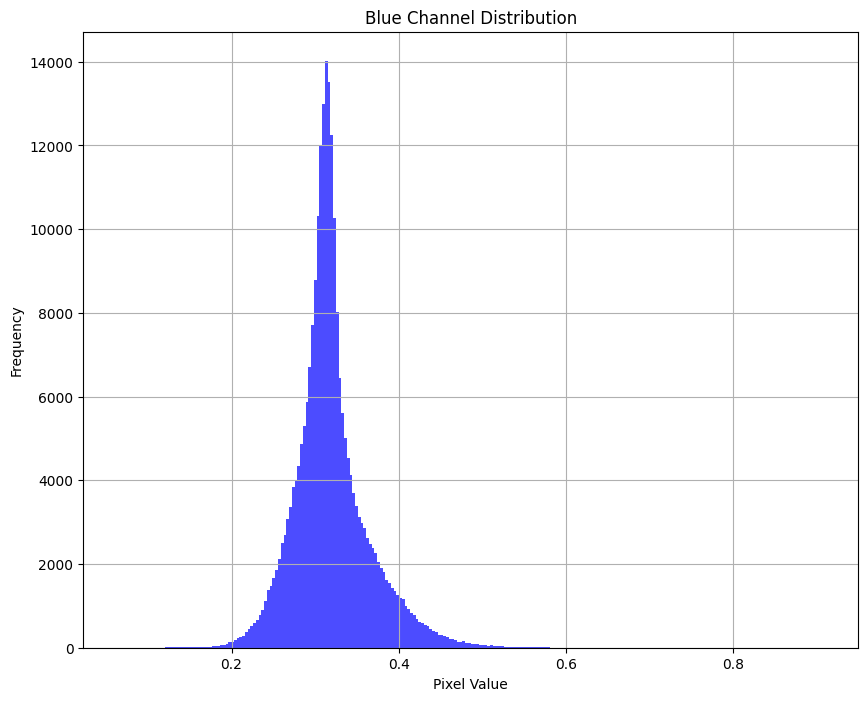

In [7]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Function to plot histograms for RGB channels
def plot_rgb_channel_histograms(X, output_folder):
    num_images, height, width, channels = X.shape  # Assuming X is reshaped back to (num_images, height, width, channels)

    # Ensure there are 3 channels (RGB)
    assert channels == 3, "The image must have 3 channels (RGB)."

    # Labels for plotting
    channel_labels = ['Red Channel', 'Green Channel', 'Blue Channel']
    colors = ['r', 'g', 'b']

    # Plotting
    for i in range(channels):
        # Extract the i-th channel data from all images
        channel_data = X[:, :, :, i].flatten()

        # Calculate statistics
        mean = np.mean(channel_data)
        median = np.median(channel_data)
        std = np.std(channel_data)
        skewness = stats.skew(channel_data)
        kurtosis = stats.kurtosis(channel_data)

        # Print statistics
        print(f"{channel_labels[i]} - Mean: {mean}, Median: {median}, Std: {std}, Skewness: {skewness}, Kurtosis: {kurtosis}")

        # Plot histogram
        plt.figure(figsize=(10, 8))
        plt.hist(channel_data, bins=256, color=colors[i], alpha=0.7)
        plt.title(f'{channel_labels[i]} Distribution')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
        plt.savefig(os.path.join(output_folder, f'{channel_labels[i].lower().replace(" ", "_")}_distribution.png'))
        plt.close()

# Reshape the ZCA whitened images back to their original format
# Make sure to replace 'X_ZCA_rescaled' with your actual variable containing the ZCA whitened and rescaled images
X_ZCA_reshaped = X_ZCA_rescaled.reshape(-1, 50, 50, 3)  # Adjust the shape (50, 50, 3) as per your actual images

# Change output folder
output_folder = 'histogram_prewhitened'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Plot and save the histograms for the RGB channels
plot_rgb_channel_histograms(X_ZCA_reshaped, output_folder)


# **Channel by Channel for original patches**

Red Channel - Mean: 41.537444, Median: 34.0, Std: 39.47808716170104, Skewness: 0.8757846908740565, Kurtosis: 0.10724058076271614


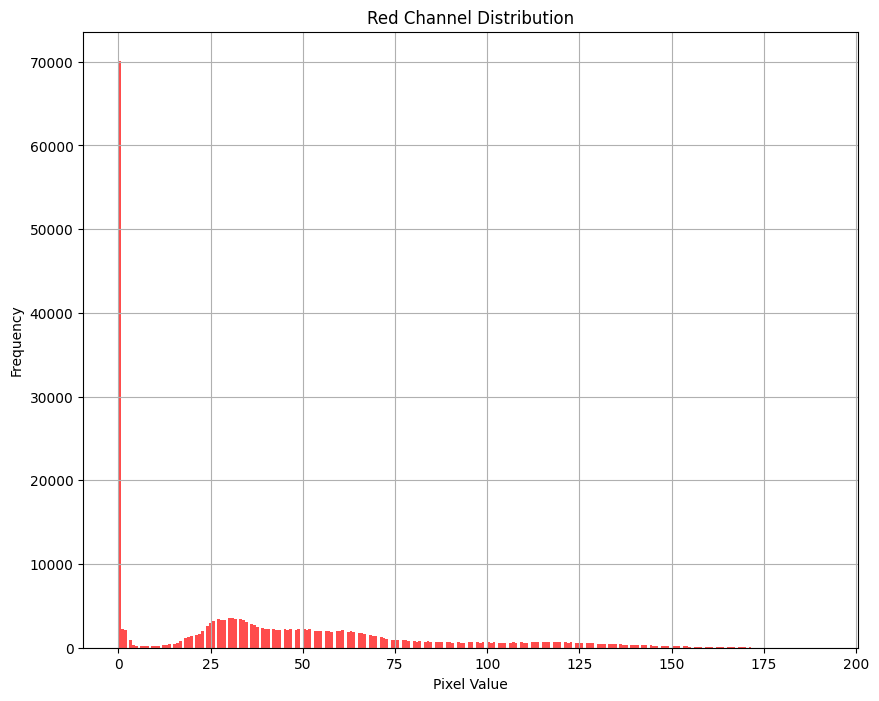

Green Channel - Mean: 61.414172, Median: 56.0, Std: 56.54373940193924, Skewness: 0.5000081182508996, Kurtosis: -0.8728891122870008


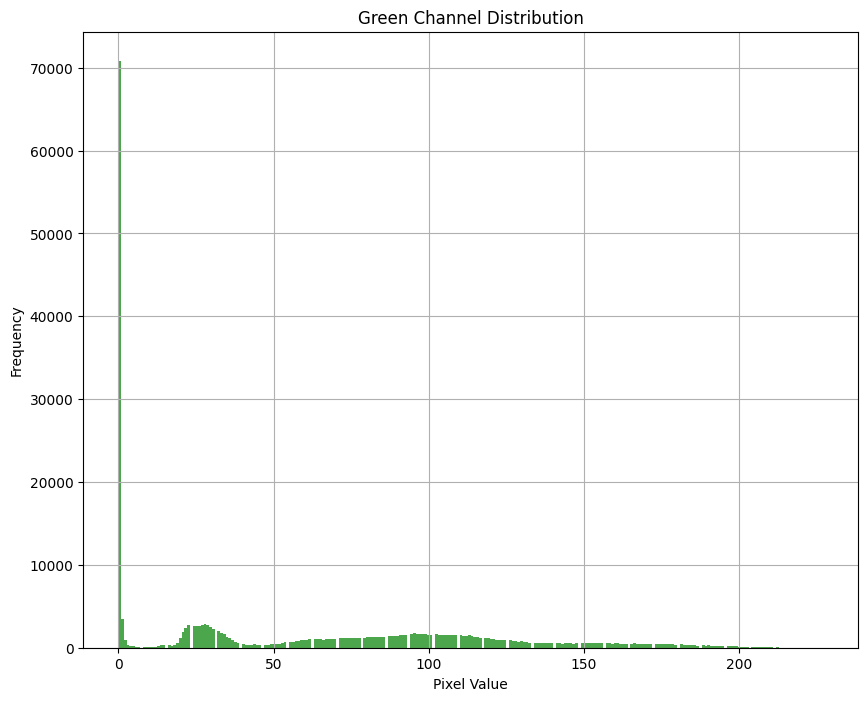

Blue Channel - Mean: 49.491444, Median: 40.0, Std: 47.17068605389224, Skewness: 0.7556862379715098, Kurtosis: -0.26350707769651827


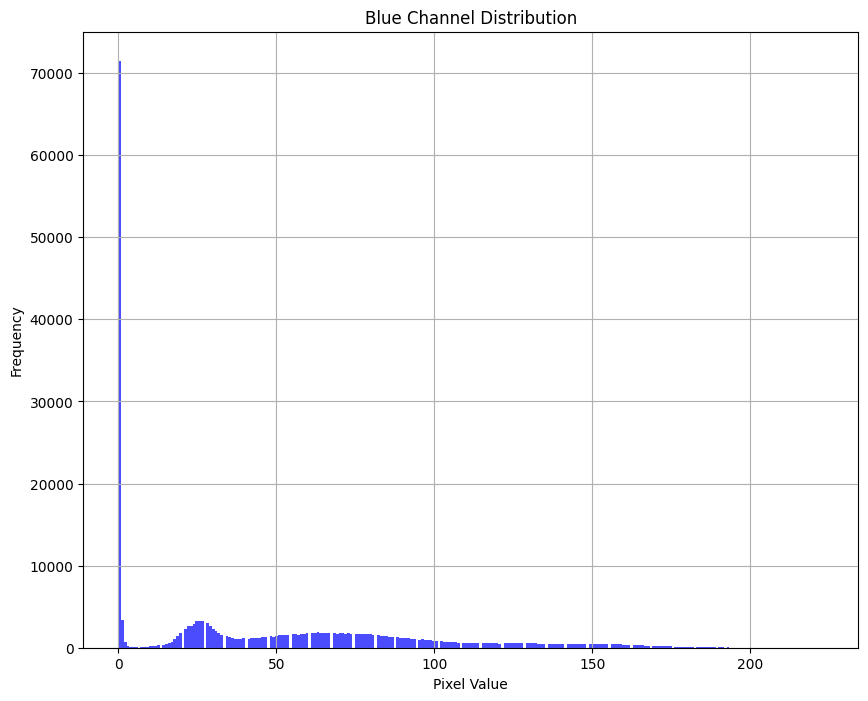

In [8]:
import matplotlib.pyplot as plt
import scipy.stats as stats
patches_output_folder = '/content/drive/MyDrive/Agricultural_Image_Analytics/AgandBio/leaves/patches'
# Function to load the extracted patches
def load_patches(folder):
    patches = []
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                patches.append(img)
    return patches

# Function to analyze and visualize the RGB channel distribution of the patches
def analyze_patches(patches):
    channel_labels = ['Red Channel', 'Green Channel', 'Blue Channel']
    colors = ['r', 'g', 'b']

    for i, channel_label in enumerate(channel_labels):
        channel_data = np.concatenate([patch[:, :, i].flatten() for patch in patches])

        # Compute statistics
        mean = np.mean(channel_data)
        median = np.median(channel_data)
        std = np.std(channel_data)
        skewness = stats.skew(channel_data)
        kurtosis = stats.kurtosis(channel_data)

        # Print statistics
        print(f"{channel_label} - Mean: {mean}, Median: {median}, Std: {std}, Skewness: {skewness}, Kurtosis: {kurtosis}")

        # Plot histogram
        plt.figure(figsize=(10, 8))
        plt.hist(channel_data, bins=256, color=colors[i], alpha=0.7)
        plt.title(f'{channel_label} Distribution')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

# Load the extracted patches
patches = load_patches(patches_output_folder)

histogram_output_folder= 'histogram_original'
# Create the output folder if it doesn't exist
os.makedirs(histogram_output_folder, exist_ok=True)

# Analyze and visualize the distribution for each RGB channel
analyze_patches(patches)
